# Diffusion Model met Fashion MNIST in PyTorch

Het doel van dit notebook is om een diffusion model te implementeren dat leert om ruis van afbeeldingen te verwijderen en nieuwe afbeeldingen van mode-items te genereren die vergelijkbaar zijn met de Fashion MNIST dataset.

## Importeren van packages en dataset

In onderstaande code worden de volgende stappen uitgevoerd:
* Laad de Fashion MNIST dataset en normaliseer de afbeeldingen naar het bereik [-1, 1]
* Maak een DataLoader om batches van trainingsgegevens te genereren
* Voeg functies toe om eenvoudiger te kunnen werken met ruis

Data geladen en DataLoader klaar.
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 9, 8, 9, 1, 2, 2, 9])


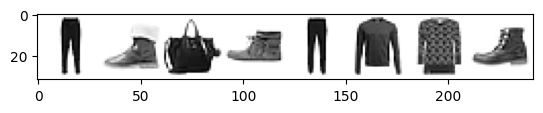

In [1]:
# Importeren van benodigde bibliotheken
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# Controleer of er een GPU beschikbaar is, zo niet gebruik de CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data-transformatie: normaliseer de afbeeldingen zodat de pixelwaarden tussen -1 en 1 liggen
transform = transforms.Compose([
    transforms.ToTensor(),  # Converteert beeld naar tensor
])

# FashionMNIST dataset downloaden en laden
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader voor batches van de trainingsdata
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

print("Data geladen en DataLoader klaar.")

x, y = next(iter(train_loader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

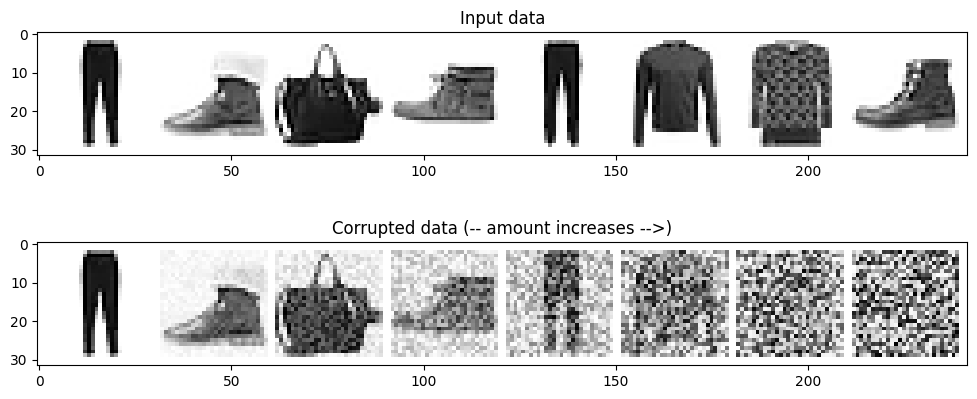

In [2]:
# Functie om het ruisen van een afbeelding te simuleren (vereenvoudigd)
def add_noise(img, amount):
    noise = torch.rand_like(img)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return img*(1-amount) + noise*amount 

# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = add_noise(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

## Bouwen van een model

In deze notebook gaan we werken met een eenvoudig U-Net model dat de taak van ruisvoorspelling uitvoert. Het model bestaat uit encoder-, midden- en decoderlagen. Het model voorspelt de ruis die is toegevoegd aan een afbeelding en probeert deze te verwijderen.
Ook andere modellen kunnen hiervoor gebruikt worden.

In [5]:
class DiffusionModel(nn.Module): # nn.Module want UNet heeft shortcuts in de netwerkarchitectuur (nn.Sequential kan dit niet)
    def __init__(self):
        super(DiffusionModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128+128, 64, kernel_size=2, stride=2) ,
            # 128 + 128 output van encoder + output van bottlneck
            # stride=2 als tegenpool van maxpool2d
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.bottleneck(x1)
        x = self.decoder(torch.cat([x1, x2], dim=1)) # waarom dimensie 1 -> eerste batch size, tweede aantal channels (samenvoegen op aantal kanalen)
        return x

model = DiffusionModel().to(device)
print(model)

x = torch.randn(8, 1, 28, 28).to(device)
print(model(x).shape)

DiffusionModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)
torch.Size([8, 1, 28, 28])


## Trainen van het model

Om het model te trainen wordt de verliesfunctie MSE-loss en de Adam-optimizer gebruikt. 
Daarnaast berekenen we de betas voor het diffusieproces met behulp van een lineaire verdeling over 1000 timesteps.

Ten slotte wordt het diffusiemodel getraind. Voor elke batch van trainingsafbeeldingen wordt een willekeurige tijdstap gekozen om ruis toe te voegen aan de afbeelding. Het model leert vervolgens de toegevoegde ruis te voorspellen en te verwijderen. Voor elke epoch wordt het verlies uitgeprint.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)

        # voeg ruis toe
        noise_amount = torch.rand(images.shape[0]).to(device) # hoe sterk de ruis is, is random per beeld
        noisy_images = add_noise(images, noise_amount)

        # de 5 stappen van het trainingsproces
        optimizer.zero_grad()
        outputs = model(noisy_images) # dit is een vereenvoudigde demo dus niet meerdere keren maar one-shot of in 1 keer alle ruis weg
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        

c:\Users\jens.baetens3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


: 

## Visualisatie

In [ ]:
x, y = next(iter(train_loader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = add_noise(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = model(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys')

### Opmerkingen:

De hierboven gevolgde aanpak is een vereenvoudigde voorstelling van de state-of-the-art diffusion model die wel goed de te volgen concepten uitlegt.
Een meer gedetailleerde uitleg van diffusion models vind je [DDPM paper](https://arxiv.org/abs/2006.11239)
In deze paper breiden ze het voorbeeld in deze notebook uit door:
* Een geavanceerder UNet-model te gebruiken
* Een complexere manier om ruis toe te voegen
* Niet rechtstreeks het begin image te voorspellen maar de ruis in een image te voorspellen
* Gebruik een timestep in plaats van een amount-waarde